In [1]:
import xarray as xr
import numpy as np
import cftime
import nc_time_axis
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
from cftime import datetime 
import matplotlib.colors as colors
import math
import random
import matplotlib.cm as mcm
jet = mcm.get_cmap('jet')
import cartopy.crs as ccrs # CRS stands for "Coordinate reference systems" for map projection
from cartopy.crs import PlateCarree
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dateutil import tz
import pytz
import time
from time import process_time
%matplotlib inline 

filename="Nc_Files/Jianfei_WACCMX_files/waccmx_Fe_Fep_02.nc"
#filename="Nc_Files/Jianfei_WACCMX_files/waccmx_Na_Nap_02.nc"
#filename="Nc_Files/Jianfei_WACCMX_files/waccmx_Mg_Mgp_02.nc"

filename2="Nc_Files/Jianfei_WACCMX_files/waccmx_T_Z3_e_02.nc"
#filename3="Nc_Files/Jianfei_WACCMX_files/waccmx_winds_02.nc"

M = filename[-9:]
Metal=M[0:2]
#print(Metal)

ds = xr.open_dataset(filename)
ds2 = xr.open_dataset(filename2)
#ds2
#ds

In [2]:
timee = ds.variables['time']
times = xr.cftime_range(start="0001-02-01", periods=672, freq="1H", calendar="noleap")
times2 = ds["time"].dt.strftime("%Y%m%d %H:%M")


In [3]:
lon = ds.variables['lon']
lat = ds.variables['lat']
lev = ds.variables['lev']

dst = ds.transpose("lev", ...)
Mt = dst.variables[str(Metal)]
Mpt = dst.variables[str(Metal)+'p']

In [4]:
ds2t = ds2.transpose("lev", ...)
temp = ds2t.variables['T']
elect = ds2t.variables['e']

geopH = ds2t.variables['Z3'] / 1000 #m-> km
Zavg = geopH.mean(('time','lat', 'lon'))


In [5]:
# Slice arrays (lev, altitude) between chosen range

lev_sl_idx_min = 42
lev_sl_idx_max = 66
lev_sl = lev[lev_sl_idx_min:lev_sl_idx_max+1]

lev_sl_ind_min = lev[lev_sl_idx_min] 
lev_sl_ind_max = lev[lev_sl_idx_max] 
lev_sl_str = str("%.1e" % lev_sl_ind_min) + ' hPa : ' + str("%.1e" % lev_sl_ind_max) + ' hPa'
print('Array lev = ' + lev_sl_str)


Zavg_sl = Zavg[lev_sl_idx_min:lev_sl_idx_max+1]

Zavg_sl_min = Zavg[lev_sl_idx_min] 
Zavg_sl_max = Zavg[lev_sl_idx_max]
Zavg_sl_str = str("%.0f" % Zavg_sl_min) + ' km : ' + str("%.0f" % Zavg_sl_max) + ' km'
print('Approx Z = ' + Zavg_sl_str)

geopH_sl = geopH[lev_sl_idx_min:lev_sl_idx_max+1,:,:,:]

Array lev = 1.5e-05 hPa : 6.0e-03 hPa
Approx Z = 128 km : 81 km


In [6]:
# Slice arrays (time) between chosen range

times_idx_min = 0
times_idx_max = 336
times_min = times[times_idx_min]
times_max = times[times_idx_max-1]
times_str_min = str(times_min)
times_str_max = str(times_max)
print('Array time = ' + times_str_min + ' : ' + times_str_max)


Array time = 0001-02-01 00:00:00 : 0001-02-14 23:00:00


In [7]:
# Slice e density and temp by chosen alt range and time range (first 2 weeks of data)

#electr = elect[lev_sl_idx_min:lev_sl_idx_max+1,times_idx_min:times_idx_max,:,:]
tempe = temp[lev_sl_idx_min:lev_sl_idx_max+1,times_idx_min:times_idx_max,:,:]

Mp_t = Mpt[lev_sl_idx_min:lev_sl_idx_max+1,times_idx_min:times_idx_max,:,:]

#electr #lev: 25 time: 336 lat: 96 lon: 144
#tempe #lev: 25 time: 336 lat: 96 lon: 144

In [8]:
# VMR to number density calculation
start_time = time.process_time()            

#edens = ( electr * 1e-6 * 100 * lev_sl ) / (1.380503e-23 * tempe)
#edens #lev: 25 time: 336 lat: 96 lon: 144

Mptdens = ( Mp_t * 1e-6 * 100 * lev_sl ) / (1.380503e-23 * tempe)

end_time = time.process_time()
print(end_time - start_time)

91.887082026


In [9]:
# Create array with time info for each day 
day = np.arange(0,24)

# Create an array with offset needed for each UT time step (24h period)
# Offset by 15 degrees lon, lon axis is in 2.5 degree intervals

os =  day * 15 / 2.5 

offset = np.empty(24, dtype=int) #Create offset array so it has same dims as day variable
for d in day:
    offset[d] =  ( int(os[d]) ) #convert floats to ints to get integer number of indices to offset by
print(offset)

# Stack multiple offset arrays to give offsets for consecutive days in the 2 week dataset 
offset2 = np.stack((offset, offset, offset, offset, offset, offset, offset), axis=0)
offset2 = np.reshape(offset2, (24*7))
offset3 = np.stack((offset2, offset2), axis=0)
offset3 = np.reshape(offset3, (168*2))
#offset3

[  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138]


In [10]:
#Create edens_sh array so it has same dims etc as edens variable
Mptdens_sh = np.ndarray(Mptdens.shape, dtype = float) 


#Iterate over timear, offsetting e density at each time by 15 degrees lon
timear = np.arange(0,336)
for it in timear:
    Mptdens_sh[:,it,:,:] = np.roll(Mptdens[:,it,:,:], offset3[it] , axis=2)
    

In [11]:
# Calculate average of offset densities along time axis
Mptdens_avg = np.mean(Mptdens_sh,  axis=1)

# Calculate std dev of offset densities along time axis
Mptdens_std = np.std(Mptdens_sh, axis=1)

In [12]:
#Calculate global average of Mp dens as fct of lev, find max over lev dimension (peak of layer)

#Mptdens_avg.shape #(25, 96, 144)
Mptdens_avg1 = np.mean(Mptdens_avg,  axis=1)
#Mptdens_avg1.shape #(25, 144)
Mptdens_avg2 = np.mean(Mptdens_avg1,  axis=1)
#Mptdens_avg2.shape #25
max_Mptdens_avg2 = np.amax(Mptdens_avg2, axis=0)
#max_Mptdens_avg2 #1205.8034370224923

In [13]:
#Calculate global average of Mp dens as fct of lev, find max over lev dimension (peak of layer)
#Calculate standard deviation of this global average layer profile over time dim, and also at max of layer

Mptdens_avg_a =  np.mean(Mptdens_sh,  axis=2) #avg over lat dim
#Mptdens_avg_a.shape #(25, 336, 144)
Mptdens_avg1_a = np.mean(Mptdens_avg_a, axis=2) #avg over lon dim
#Mptdens_avg1_a.shape #(25, 336)
Mptdens_avg2_a = np.mean(Mptdens_avg1_a, axis=1) #avg over time dim
#print(Mptdens_avg2_a.shape) #25

max_Mptdens_avg2_a = np.amax(Mptdens_avg2_a, axis=0) # find max over lev dim
#print(max_Mptdens_avg2_a) #1205.8034370224918

argmax_Mptdens_avg2_a = np.argmax(Mptdens_avg2_a, axis=0) # find max over lev dim
#print(argmax_Mptdens_avg2_a) #16

#Std dev of global average layer over time dim
Mptdens_std_a = np.std(Mptdens_avg1_a, axis=1) #find std dev of Mptdens_avg1_a (dims lev, time) over time dim
#Mptdens_std_a.shape #25

std_max_Mptdens = Mptdens_std_a[argmax_Mptdens_avg2_a]
#std_max_Mptdens #161.1891816368939

In [14]:
levar = np.arange(0,25)
latar = np.arange(0,96)
lonar = np.arange(0,144)

In [18]:
# Calculate difference between e density from model output and the average e density 
# Where the difference is less than set value of sigma, set to NaN

sigma_val = 1   #1sigma~68%   1.5sigma~87%    2sigma~95%
sigma_val_str = str(sigma_val)

Mptdens_diff = np.ndarray(Mptdens.shape, dtype = float) 

#SpEs = np.ndarray(Mptdens.shape, dtype = float) 

SpEs_sh_1 = np.ndarray(Mptdens.shape, dtype = float)


SpEs_sh = np.ndarray(Mptdens.shape, dtype = float) 
SpEs_sh2 = np.ndarray(Mptdens.shape, dtype = float) 
SpEs_sh_mx = np.ndarray(Mptdens.shape, dtype = float)
SpEs_sh_mx1 = np.ndarray(Mptdens.shape, dtype = float)
SpEs_sh_mx2 = np.ndarray(Mptdens.shape, dtype = float)


for it in timear:
    Mptdens_diff[:,it,:,:] = Mptdens_sh[:,it,:,:] - Mptdens_avg 

SpEs_sh_nan = np.empty(Mptdens.shape)
SpEs_sh_nan[:] = np.NaN

#SpEs_lim = 1e4

#-----------------------------------------------------------------------
# (A) Condition 1 (diff > x sigma)
for it in timear:
    SpEs_sh_1[:,it,:,:] = np.where( Mptdens_diff[:,it,:,:]>(sigma_val*Mptdens_std) , Mptdens_sh[:,it,:,:] , SpEs_sh_nan[:,it,:,:] ) 

#-----------------------------------------------------------------------   
# (B) Condition 1 (diff > x sigma) & Mpt > glb average at height x
for it in timear:
    for ilev in levar:
        SpEs_sh[ilev,it,:,:] = np.where( (Mptdens_diff[ilev,it,:,:]>(sigma_val*Mptdens_std[ilev,:,:])) & (Mptdens_sh[ilev,it,:,:] > (Mptdens_avg2[ilev])) , Mptdens_sh[ilev,it,:,:] , SpEs_sh_nan[ilev,it,:,:] )

#-----------------------------------------------------------------------
# (C) ** Condition 1 (diff > x sigma) & Mpt > glb average at height peak of glb avg layer **
for it in timear:        
    SpEs_sh_mx[:,it,:,:] = np.where( (Mptdens_diff[:,it,:,:]>(sigma_val*Mptdens_std[:,:,:])) & (Mptdens_sh[:,it,:,:] > (max_Mptdens_avg2)) , Mptdens_sh[:,it,:,:] , SpEs_sh_nan[:,it,:,:] )

#-----------------------------------------------------------------------
# (D) Mpt > glb average at height peak of glb avg layer 
for it in timear:
    SpEs_sh_mx1[:,it,:,:] = np.where( (Mptdens_sh[:,it,:,:] > (max_Mptdens_avg2)) , Mptdens_sh[:,it,:,:] , SpEs_sh_nan[:,it,:,:] )

#-----------------------------------------------------------------------
# (E) diff > 0.5 sigma & Mpt > glb average at height peak of glb avg layer 
for it in timear:
    SpEs_sh_mx2[:,it,:,:] = np.where( (Mptdens_diff[:,it,:,:]>(0.5*Mptdens_std[:,:,:])) & (Mptdens_sh[:,it,:,:] > (max_Mptdens_avg2)) , Mptdens_sh[:,it,:,:] , SpEs_sh_nan[:,it,:,:] )
#-----------------------------------------------------------------------

# (F) Condition 1 (diff > x sigma) & Mpt > 3x glb average at height x 

# (2) & 3x std dev at glb avg layer peak
# (3) & 3x std dev


for it in timear:
    for ilev in levar:
        SpEs_sh2[ilev,it,:,:] = np.where( (Mptdens_diff[ilev,it,:,:]>(sigma_val*Mptdens_std[ilev,:,:])) 
                                         & (Mptdens_sh[ilev,it,:,:] > (3. * Mptdens_avg2[ilev])) 
                                         & (Mptdens_sh[ilev,it,:,:]>(3.* std_max_Mptdens))      #(2)
                                         #& (Mptdens_sh[ilev,it,:,:]>(2. * Mptdens_std[ilev,:,:]))   #(3)
                                         , Mptdens_sh[ilev,it,:,:] , SpEs_sh_nan[ilev,it,:,:] )
#-----------------------------------------------------------------------

    
#Set string values for sigma symbol to use in plot
sigma_symb_str = 'sigma: \u03C3'
sigma = sigma_symb_str[-1]


In [19]:
#(A)-----------Condition 1 (diff > x sigma) -----------------------------------------------------------------

#Create array, where SpEs_sh is a number, set to True, otherwise set to False
SpEs_sh_1_freq = np.empty(Mptdens.shape)
SpEs_sh_1_freq_bool = np.isfinite(SpEs_sh_1) 
SpEs_sh_1_freq = SpEs_sh_1_freq_bool *1. #Convert True/False to 1/0s

#Sum over Time dimension to give SpEs_sh_freq_time variable (total occurences in 2 week time period)
SpEs_sh_1_freq_time = np.empty(Mptdens_avg.shape)
SpEs_sh_1_freq_time = np.sum(SpEs_sh_1_freq, axis=1) 

#Divide by number of timesteps to give occurence freq (%)
timedim_len = np.size(SpEs_sh_1_freq, axis=1) #336
SpEs_Occ_Freq_1 = ( SpEs_sh_1_freq_time / timedim_len ) *100.


#(B)-----------Condition 1 (diff > x sigma) & Mpt > glb average at height x  -----------------------------------------------------------------

#Create array, where SpEs_sh is a number, set to True, otherwise set to False
SpEs_sh_freq = np.empty(Mptdens.shape)
SpEs_sh_freq_bool = np.isfinite(SpEs_sh) 
SpEs_sh_freq = SpEs_sh_freq_bool *1. #Convert True/False to 1/0s

#Sum over Time dimension to give SpEs_sh_freq_time variable (total occurences in 2 week time period)
SpEs_sh_freq_time = np.empty(Mptdens_avg.shape)
SpEs_sh_freq_time = np.sum(SpEs_sh_freq, axis=1) 

#Divide by number of timesteps to give occurence freq (%)
timedim_len = np.size(SpEs_sh_freq, axis=1) #336
SpEs_Occ_Freq = ( SpEs_sh_freq_time / timedim_len ) *100.


#(C)-----------** Condition 1 (diff > x sigma) & Mpt > glb average at height peak of glb avg layer ** -----------------------------------------------------------------

#Create array, where SpEs_sh is a number, set to True, otherwise set to False
SpEs_sh_mx_freq = np.empty(Mptdens.shape)
SpEs_sh_mx_freq_bool = np.isfinite(SpEs_sh_mx) 
SpEs_sh_mx_freq = SpEs_sh_mx_freq_bool *1. #Convert True/False to 1/0s

#Sum over Time dimension to give SpEs_sh_freq_time variable (total occurences in 2 week time period)
SpEs_sh_mx_freq_time = np.empty(Mptdens_avg.shape)
SpEs_sh_mx_freq_time = np.sum(SpEs_sh_mx_freq, axis=1) 

#Divide by number of timesteps to give occurence freq (%)
timedim_len = np.size(SpEs_sh_mx_freq, axis=1) #336
SpEs_Occ_Freq_mx = ( SpEs_sh_mx_freq_time / timedim_len ) *100.


#(D)----------- diff > 0.5 sigma & Mpt > glb average at height peak of glb avg layer -----------------------------------------------------------------

#Create array, where SpEs_sh is a number, set to True, otherwise set to False
SpEs_sh_mx1_freq = np.empty(Mptdens.shape)
SpEs_sh_mx1_freq_bool = np.isfinite(SpEs_sh_mx1) 
SpEs_sh_mx1_freq = SpEs_sh_mx1_freq_bool *1. #Convert True/False to 1/0s

#Sum over Time dimension to give SpEs_sh_freq_time variable (total occurences in 2 week time period)
SpEs_sh_mx1_freq_time = np.empty(Mptdens_avg.shape)
SpEs_sh_mx1_freq_time = np.sum(SpEs_sh_mx1_freq, axis=1) 

#Divide by number of timesteps to give occurence freq (%)
timedim_len = np.size(SpEs_sh_mx1_freq, axis=1) #336
SpEs_Occ_Freq_mx1 = ( SpEs_sh_mx1_freq_time / timedim_len ) *100.


#(E)----------- Mpt > glb average at height peak of glb avg layer -----------------------------------------------------------------

#Create array, where SpEs_sh is a number, set to True, otherwise set to False
SpEs_sh_mx2_freq = np.empty(Mptdens.shape)
SpEs_sh_mx2_freq_bool = np.isfinite(SpEs_sh_mx2) 
SpEs_sh_mx2_freq = SpEs_sh_mx2_freq_bool *1. #Convert True/False to 1/0s

#Sum over Time dimension to give SpEs_sh_freq_time variable (total occurences in 2 week time period)
SpEs_sh_mx2_freq_time = np.empty(Mptdens_avg.shape)
SpEs_sh_mx2_freq_time = np.sum(SpEs_sh_mx2_freq, axis=1) 

#Divide by number of timesteps to give occurence freq (%)
timedim_len = np.size(SpEs_sh_mx2_freq, axis=1) #336
SpEs_Occ_Freq_mx2 = ( SpEs_sh_mx2_freq_time / timedim_len ) *100.


#(F)-----------Condition 1 (diff > x sigma) & Mpt > 3x glb average at height x  -----------------------------------------------------------------

#Create array, where SpEs_sh is a number, set to True, otherwise set to False
SpEs_sh2_freq = np.empty(Mptdens.shape)
SpEs_sh2_freq_bool = np.isfinite(SpEs_sh2) 
SpEs_sh2_freq = SpEs_sh2_freq_bool *1. #Convert True/False to 1/0s

#Sum over Time dimension to give SpEs_sh_freq_time variable (total occurences in 2 week time period)
SpEs_sh2_freq_time = np.empty(Mptdens_avg.shape)
SpEs_sh2_freq_time = np.sum(SpEs_sh2_freq, axis=1) 

#Divide by number of timesteps to give occurence freq (%)
timedim_len = np.size(SpEs_sh2_freq, axis=1) #336
SpEs_Occ_Freq2 = ( SpEs_sh2_freq_time / timedim_len ) *100.


In [38]:
# Bin into 0.5h bins instead of 10 mins (at the point where converted to 1/0s, before summing over time)

#(C)-----------** Condition 1 (diff > x sigma) & Mpt > glb average at height peak of glb avg layer ** -----------------------------------------------------------------

#Create array, where SpEs_sh is a number, set to True, otherwise set to False
SpEs_sh_mx_freq = np.empty(Mptdens.shape)
SpEs_sh_mx_freq_bool = np.isfinite(SpEs_sh_mx) 
SpEs_sh_mx_freq = SpEs_sh_mx_freq_bool *1. #Convert True/False to 1/0s


SpEs_sh_mx_freq_binned = np.empty((25, 336, 96, 48), dtype=float)
SpEs_sh_mx_freq_temp = np.empty((25, 336, 96, 3), dtype=float)


start_time = time.process_time()

it_ar = np.arange(1,48) # array 1->47
for ilev in levar:
    for it in timear:
        for ilat in latar:
            SpEs_sh_mx_freq_temp[ilev,it,ilat,0] = SpEs_sh_mx_freq[ilev,it,ilat,-1]
            SpEs_sh_mx_freq_temp[ilev,it,ilat,1] = SpEs_sh_mx_freq[ilev,it,ilat,0]
            SpEs_sh_mx_freq_temp[ilev,it,ilat,2] = SpEs_sh_mx_freq[ilev,it,ilat,1]
            SpEs_sh_mx_freq_binned[ilev,it,ilat,0] = np.mean(SpEs_sh_mx_freq_temp[ilev,it,ilat,:])
            for iit_ar in it_ar:
                SpEs_sh_mx_freq_temp[ilev,it,ilat,:] = SpEs_sh_mx_freq[ilev,it,ilat,((iit_ar*3)-1):((iit_ar*3)+2)]
                SpEs_sh_mx_freq_binned[ilev,it,ilat,iit_ar] = np.mean(SpEs_sh_mx_freq_temp[ilev,it,ilat,:])
                

end_time = time.process_time()
print(end_time - start_time) #256 ~4.3mins


#Sum over Time dimension to give SpEs_sh_freq_time variable (total occurences in 2 week time period)
SpEs_sh_mx_fr_b_time = np.empty(Mptdens_avg.shape)
SpEs_sh_mx_fr_b_time = np.sum(SpEs_sh_mx_freq_binned, axis=1) 

#Divide by number of timesteps to give occurence freq (%)
timedim_len = np.size(SpEs_sh_mx_freq_binned, axis=1) #336
SpEs_Occ_Freq_mx_b = ( SpEs_sh_mx_fr_b_time / timedim_len ) *100.


256.68201196600006


In [20]:
# Bin into 0.5h bins instead of 10 mins 
# Calculation done after summing over time to get occurence freq (%). Gets same result as when rebinned before summing (SpEs_Occ_Freq_mx_b) but much faster

#(C)-----------** Condition 1 (diff > x sigma) & Mpt > glb average at height peak of glb avg layer ** -----------------------------------------------------------------

SpEs_Occ_Freq_mx_temp = np.empty((25, 96, 3), dtype=float)
SpEs_Occ_Freq_mx_b2 = np.empty((25, 96, 48), dtype=float)

it_ar = np.arange(1,48) # array 1->47

start_time = time.process_time()

for ilev in levar:
    for ilat in latar:
        SpEs_Occ_Freq_mx_temp[ilev,ilat,0] = SpEs_Occ_Freq_mx[ilev,ilat,-1]
        SpEs_Occ_Freq_mx_temp[ilev,ilat,1] = SpEs_Occ_Freq_mx[ilev,ilat,0]
        SpEs_Occ_Freq_mx_temp[ilev,ilat,2] = SpEs_Occ_Freq_mx[ilev,ilat,1]
        SpEs_Occ_Freq_mx_b2[ilev,ilat,0] = np.mean(SpEs_Occ_Freq_mx_temp[ilev,ilat,:])
        for iit_ar in it_ar:
            SpEs_Occ_Freq_mx_temp[ilev,ilat,:] = SpEs_Occ_Freq_mx[ilev,ilat,((iit_ar*3)-1):((iit_ar*3)+2)]
            SpEs_Occ_Freq_mx_b2[ilev,ilat,iit_ar] = np.mean(SpEs_Occ_Freq_mx_temp[ilev,ilat,:])
          
end_time = time.process_time()
print(end_time - start_time) #0.78

1.2493825189999939


In [42]:
#------------------------ Plot 2 setup: SpEs_plot-----------------------------

lat_plot2_idx = 21 #=-50.2   #37 #=-19.9    
lat_plot2 = lat[lat_plot2_idx]
lat_plot2_str = str("%.1f" % lat_plot2) 
print('Plot lat = ' + lat_plot2_str)

lev_sl_idx_min = 0
lev_sl_idx_max = -1
lev_sl_plot2_min = lev_sl[lev_sl_idx_min]
lev_sl_plot2_max = lev_sl[lev_sl_idx_max]
lev_sl_plot2_min_str = str("%.1e" % lev_sl_plot2_min) + ' hPa'
lev_sl_plot2_max_str = str("%.1e" % lev_sl_plot2_max) + ' hPa'
print('Lev = ' + lev_sl_plot2_max_str + ' : ' + lev_sl_plot2_min_str)

Zavg_sl_plot2_min = Zavg_sl[0]
Zavg_sl_plot2_max = Zavg_sl[-1]
Zavg_sl_plot2_min_str = str("%.0f" % Zavg_sl_plot2_min) + ' km'
Zavg_sl_plot2_max_str = str("%.0f" % Zavg_sl_plot2_max) + ' km'
print('Approx Z = ' + Zavg_sl_plot2_max_str + ' : ' + Zavg_sl_plot2_min_str)

Plot lat = -50.2
Lev = 6.0e-03 hPa : 1.5e-05 hPa
Approx Z = 81 km : 128 km


In [43]:

#----------------Set up Local Time Ticks-------------------------

timeconv = lon / 15
timeconv_plot = timeconv.to_numpy() 

timeconv_plot_ticks = np.arange(0,25, dtype=float)


/tmp/ipykernel_1183944/3496795863.py:59: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.12)#,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023,
/tmp/ipykernel_1183944/3496795863.py:59: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.12)#,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023,
/tmp/ipykernel_1183944/3496795863.py:59: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To s

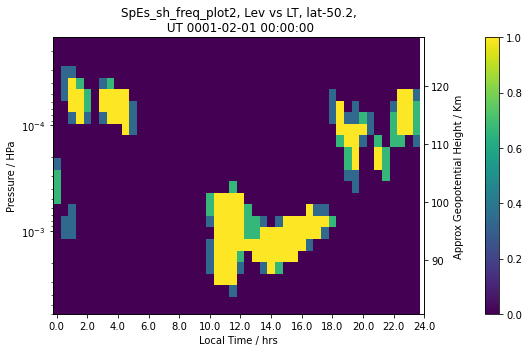

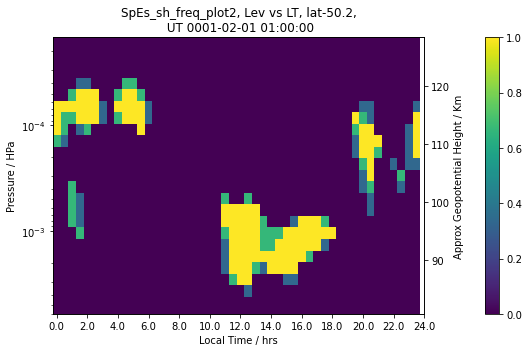

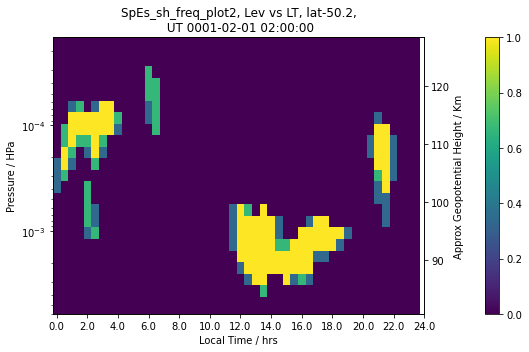

In [118]:
#---------------------------------------------------------------------------------------------------
#-----------------------------------Lev-LT----------------------------------------------------
#---------------------------------------------------------------------------------------------------


time_plot2_idx_start = 0  
time_plot2_idx_end = 3

time_plot2_ar = np.arange(time_plot2_idx_start,time_plot2_idx_end)

for itime in time_plot2_ar:
    time_plot2_idx = time_plot2_ar[itime]

    
    #--------------- Plot 1 setup: time -------------------------
    time_plot2 = timee[time_plot2_idx]
    times_plot2 = times[time_plot2_idx]
    times_plot2_str = str(times_plot2)
    #print('Plot time = ' + times_plot1_str)   

    #---------------Set up plot variables----------------------------

    SpEs_sh_freq_bool_plot2 = SpEs_sh_freq_bool[:,time_plot2_idx,lat_plot2_idx,:]
    SpEs_sh_freq_plot2 = SpEs_sh_freq[:,time_plot2_idx,lat_plot2_idx,:]    
    
    SpEs_sh_mx_freq_plot2 = SpEs_sh_mx_freq[:,time_plot2_idx,lat_plot2_idx,:] #(25, 336, 96, 144)
    SpEs_sh_mx_freq_binned_plot2 = SpEs_sh_mx_freq_binned[:,time_plot2_idx,lat_plot2_idx,:] #(25, 336, 96, 48)
 
    
    #------------------------ SpEs_sh_freq_time_plot -----------------------------

    #ticks = np.linspace(0, 40, 33)

    fig, ax = plt.subplots(figsize=(8, 5))
    
    #C = ax.contourf(timeconv_plot, lev_sl, SpEs_sh_freq_plot2, 
                 #levels=ticks,
                 #locator=ticker.LogLocator(),
                 #extend='min',
    #             cmap=jet)   
                    
    C = ax.pcolormesh(timeconv_plot[::3], lev_sl, SpEs_sh_mx_freq_binned_plot2) 

    ax.set_yscale('log')
    ax.set_ylabel('Pressure / HPa')
    ax.set_ylim(lev_sl_plot2_max, lev_sl_plot2_min) 

    ax2 = ax.twinx()
    ax2.set_ylabel('Approx Geopotential Height / Km')
    ax2.set_ylim(Zavg_sl_plot2_max,Zavg_sl_plot2_min)


    ax.set_xlabel('Local Time / hrs')
    ax.set_xticks(np.linspace(0,24,13)) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title('SpEs_sh_freq_plot2, Lev vs LT, lat' + lat_plot2_str + ',\n UT ' + times_plot2_str )

    cbar = fig.colorbar(C, pad=0.12)#,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    #cbar.set_label(r'Number of Occurences')

    figname='SpEs_sh_mx_freq_binned_plot2: Lev vs LT, lat' + lat_plot2_str + ' ' + times_plot2_str + '.png'
    plt.tight_layout()
    #plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/'+str(figname), dpi = 400) #



/tmp/ipykernel_1667786/3741320274.py:46: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.12)#,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023,


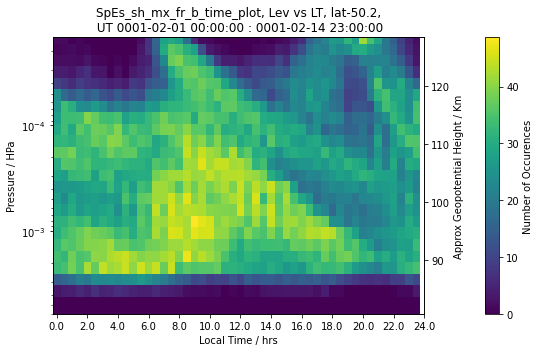

In [46]:
#---------------------------------------------------------------------------------------------------
#-----------------------------------Lev-LT----------------------------------------------------
#---------------------------------------------------------------------------------------------------

#---------------Set up plot variables----------------------------
SpEs_sh_freq_time_plot = SpEs_sh_freq_time[:,lat_plot2_idx,:]

SpEs_sh_mx_fr_b_time_plot = SpEs_sh_mx_fr_b_time[:,lat_plot2_idx,:]

#------------------------ SpEs_sh_freq_time_plot -----------------------------

#ticks = np.linspace(0, 120, 33)

fig, ax = plt.subplots(figsize=(8, 5))
#C = ax.contourf(timeconv_plot, lev_sl, SpEs_sh_freq_time_plot, 
#                 levels=ticks,
                 #locator=ticker.LogLocator(),
                 #extend='min',
#                 cmap=jet)


C = ax.pcolormesh(timeconv_plot[::3], lev_sl, SpEs_sh_mx_fr_b_time_plot)


ax.set_yscale('log')
ax.set_ylabel('Pressure / HPa')
ax.set_ylim(lev_sl_plot2_max, lev_sl_plot2_min) 

ax2 = ax.twinx()
ax2.set_ylabel('Approx Geopotential Height / Km')
ax2.set_ylim(Zavg_sl_plot2_max,Zavg_sl_plot2_min)


ax.set_xlabel('Local Time / hrs')
ax.set_xticks(np.linspace(0,24,13)) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title('SpEs_sh_mx_fr_b_time_plot, Lev vs LT, lat' + lat_plot2_str + ',\n UT ' + times_str_min + ' : ' + times_str_max )

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, pad=0.12)#,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

cbar.set_label(r'Number of Occurences')

figname='SpEs_sh_mx_fr_b_time_plot: Lev vs LT, lat' + lat_plot2_str + ' ' + times_str_min + ' : ' + times_str_max + '.png'
plt.tight_layout()
plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/'+str(figname), dpi = 400) #



/tmp/ipykernel_1667786/4180681384.py:56: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023,


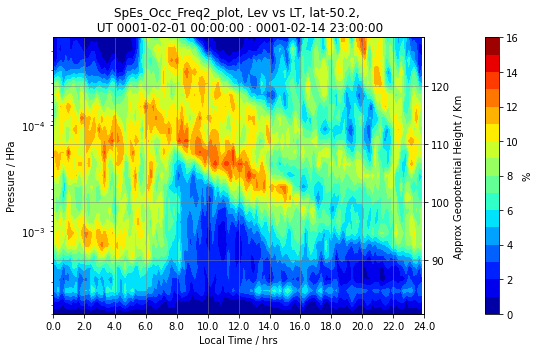

In [89]:
#---------------------------------------------------------------------------------------------------
#-----------------------------------Lev-LT----------------------------------------------------
#---------------------------------------------------------------------------------------------------

#---------------Set up plot variables----------------------------

SpEs_Occ_Freq_1_plot = SpEs_Occ_Freq_1[:,lat_plot2_idx,:] #Condition 1 (diff > x sigma)
SpEs_Occ_Freq_plot = SpEs_Occ_Freq[:,lat_plot2_idx,:] #Condition 1 (diff > x sigma) & Mpt > glb average at height x
SpEs_Occ_Freq_mx_plot = SpEs_Occ_Freq_mx[:,lat_plot2_idx,:] #Condition 1 (diff > x sigma) & Mpt > glb average at height peak of glb avg layer 
SpEs_Occ_Freq_mx1_plot = SpEs_Occ_Freq_mx1[:,lat_plot2_idx,:] # Mpt > glb average at height peak of glb avg layer
SpEs_Occ_Freq_mx2_plot = SpEs_Occ_Freq_mx2[:,lat_plot2_idx,:] # diff > 0.5 sigma & Mpt > glb average at height peak of glb avg layer
SpEs_Occ_Freq2_plot = SpEs_Occ_Freq2[:,lat_plot2_idx,:] #Condition 1 (diff > x sigma) & Mpt > 3x glb average at height x

SpEs_Occ_Freq_mx_b_plot = SpEs_Occ_Freq_mx_b[:,lat_plot2_idx,:] #binned into 30 min intervals at the point where converted to 1/0s
SpEs_Occ_Freq_mx_b2_plot = SpEs_Occ_Freq_mx_b2[:,lat_plot2_idx,:] #binned into 30 min intervals once the % occurence freq calc'd. Gets same result as SpEs_Occ_Freq_mx_b

#------------------------ SpEs_Occ_Freq_plot -----------------------------

ticks = np.linspace(0, 16, 17)
#ticks = np.linspace(0, 50, 26) #SpEs_Occ_Freq_mx1_plot
#ticks = np.linspace(0, 25, 26) #SpEs_Occ_Freq_mx2_plot

fig, ax = plt.subplots(figsize=(8, 5))

C = ax.contourf(timeconv_plot, lev_sl, SpEs_Occ_Freq2_plot, #SpEs_Occ_Freq_mx_b2_plot, 
#C = ax.contourf(timeconv_plot[::3], lev_sl, SpEs_Occ_Freq_mx_b2_plot, 
                 levels=ticks,
                 #locator=ticker.LogLocator(),
                 #extend='min',
                 cmap=jet)

ax.set_yscale('log')
ax.set_ylabel('Pressure / HPa')
ax.set_ylim(lev_sl_plot2_max, lev_sl_plot2_min) 

ax2 = ax.twinx()
ax2.set_ylabel('Approx Geopotential Height / Km')
ax2.set_ylim(Zavg_sl_plot2_max,Zavg_sl_plot2_min)


ax.set_xlabel('Local Time / hrs')
ax.set_xticks(np.linspace(0,24,13)) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title('SpEs_Occ_Freq2_plot, Lev vs LT, lat' + lat_plot2_str + ', \n UT ' + times_str_min + ' : ' + times_str_max )

ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

cbar.set_label(r'%')

figname='SpEs_Occ_Freq2_plot: Lev vs LT, lat' + lat_plot2_str + ' ' + times_str_min + ' : ' + times_str_max + '(2).png'
plt.tight_layout()
plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/'+str(figname), dpi = 400) #


/tmp/ipykernel_1183944/774716758.py:47: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023,


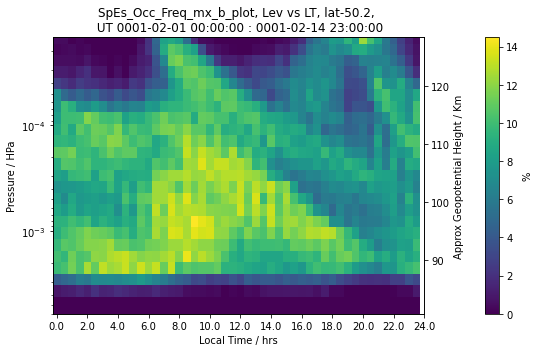

In [121]:
#---------------------------------------------------------------------------------------------------
#-----------------------------------Lev-LT----------------------------------------------------
#---------------------------------------------------------------------------------------------------

#---------------Set up plot variables----------------------------

SpEs_Occ_Freq_1_plot = SpEs_Occ_Freq_1[:,lat_plot2_idx,:] #Condition 1 (diff > x sigma)
SpEs_Occ_Freq_plot = SpEs_Occ_Freq[:,lat_plot2_idx,:] #Condition 1 (diff > x sigma) & Mpt > glb average at height x
SpEs_Occ_Freq_mx_plot = SpEs_Occ_Freq_mx[:,lat_plot2_idx,:] #Condition 1 (diff > x sigma) & Mpt > glb average at height peak of glb avg layer 
SpEs_Occ_Freq_mx1_plot = SpEs_Occ_Freq_mx1[:,lat_plot2_idx,:] # Mpt > glb average at height peak of glb avg layer
SpEs_Occ_Freq_mx2_plot = SpEs_Occ_Freq_mx2[:,lat_plot2_idx,:] # diff > 0.5 sigma & Mpt > glb average at height peak of glb avg layer
SpEs_Occ_Freq2_plot = SpEs_Occ_Freq2[:,lat_plot2_idx,:] #Condition 1 (diff > x sigma) & Mpt > 3x glb average at height x

SpEs_Occ_Freq_mx_b_plot = SpEs_Occ_Freq_mx_b[:,lat_plot2_idx,:]

#------------------------ SpEs_Occ_Freq_plot -----------------------------

#ticks = np.linspace(0, 16, 17)
#ticks = np.linspace(0, 50, 26) #SpEs_Occ_Freq_mx1_plot
ticks = np.linspace(0, 25, 26) #SpEs_Occ_Freq_mx2_plot


fig, ax = plt.subplots(figsize=(8, 5))
C = ax.pcolormesh(timeconv_plot[::3], lev_sl, SpEs_Occ_Freq_mx_b_plot)

ax.set_yscale('log')
ax.set_ylabel('Pressure / HPa')
ax.set_ylim(lev_sl_plot2_max, lev_sl_plot2_min) 

ax2 = ax.twinx()
ax2.set_ylabel('Approx Geopotential Height / Km')
ax2.set_ylim(Zavg_sl_plot2_max,Zavg_sl_plot2_min)


ax.set_xlabel('Local Time / hrs')
ax.set_xticks(np.linspace(0,24,13)) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title('SpEs_Occ_Freq_mx_b_plot, Lev vs LT, lat' + lat_plot2_str + ', \n UT ' + times_str_min + ' : ' + times_str_max )

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

cbar.set_label(r'%')

figname='SpEs_Occ_Freq_mx_b_plot_pmesh: Lev vs LT, lat' + lat_plot2_str + ' ' + times_str_min + ' : ' + times_str_max + '.png'
plt.tight_layout()
plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/'+str(figname), dpi = 400) #


In [ ]:
#------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------

In [79]:
#------------------------ Plot 1 setup: SpEs_plot-----------------------------

lev_sl_plot1_idx = 3    #3#~117km   #15 #~94km      #23=82km low lim?
lev_sl_plot1 = lev_sl[lev_sl_plot1_idx]
lev_sl_plot1_str = str("%.1e" % lev_sl_plot1) + ' hPa'
print('Plot lev = ' + lev_sl_plot1_str)


Zavg_slplot1 = Zavg_sl[lev_sl_plot1_idx]
Zavg_sl_plot1_str = str("%.0f" % Zavg_slplot1) + ' km'
print('Approx Z = ' + Zavg_sl_plot1_str)

Plot lev = 3.1e-05 hPa
Approx Z = 117 km


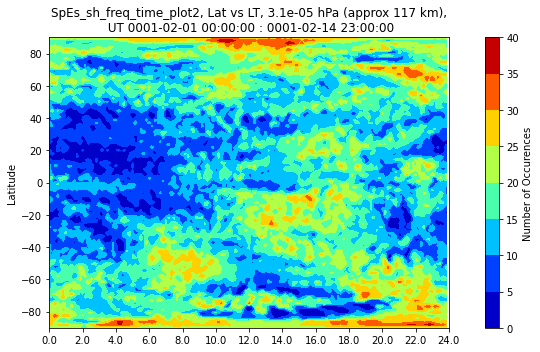

In [80]:
#---------------Set up plot variables----------------------------

SpEs_sh_freq_time_plot2 = SpEs_sh_freq_time[lev_sl_plot1_idx,:,:]

#------------------------ SpEs_sh_freq_time_plot2  -----------------------------

#ticks = np.linspace(0, 40, 21)

fig, ax = plt.subplots(figsize=(8, 5))
C = ax.contourf(timeconv_plot, lat, SpEs_sh_freq_time_plot2, 
                 #levels=ticks,
                 #locator=ticker.LogLocator(),
                 #extend='min',
                 cmap=jet)

ax.set_ylabel('Latitude')
ax.set_xticks(np.linspace(0,24,13)) 
#ax.set_xticklabels(LT_plot_ticks[::2]) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title('SpEs_sh_freq_time_plot2, Lat vs LT, ' + lev_sl_plot1_str + ' (approx ' + Zavg_sl_plot1_str + '),\n UT ' + times_str_min + ' : ' + times_str_max  )

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, pad=0.07)#,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

cbar.set_label(r'Number of Occurences')

figname='SpEs_sh_freq_time_plot2: Lat vs LT ' + lev_sl_plot1_str + times_str_min + ' : ' + times_str_max + '.png'
plt.tight_layout()
plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/'+str(figname), dpi = 300) #

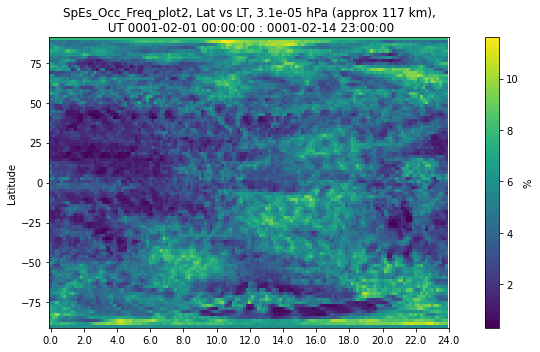

In [81]:
#---------------Set up plot variables----------------------------

SpEs_Occ_Freq_plot2 = SpEs_Occ_Freq[lev_sl_plot1_idx,:,:]

#------------------------ SpEs_sh_freq_time_plot2  -----------------------------

#ticks = np.linspace(0, 12, 13)

fig, ax = plt.subplots(figsize=(8, 5))
#C = ax.contourf(timeconv_plot, lat, SpEs_Occ_Freq_plot2, 
                 #levels=ticks,
                 #locator=ticker.LogLocator(),
                 #extend='min',
#                 cmap=jet)

C = ax.pcolormesh(timeconv_plot, lat, SpEs_Occ_Freq_plot2)

ax.set_ylabel('Latitude')
ax.set_xticks(np.linspace(0,24,13)) 
#ax.set_xticklabels(LT_plot_ticks[::2]) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title('SpEs_Occ_Freq_plot2, Lat vs LT, ' + lev_sl_plot1_str + ' (approx ' + Zavg_sl_plot1_str + '),\n UT ' + times_str_min + ' : ' + times_str_max  )

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, pad=0.07)#,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

cbar.set_label(r'%')

figname='SpEs_Occ_Freq_plot2: Lat vs LT ' + lev_sl_plot1_str + times_str_min + ' : ' + times_str_max + '.png'
plt.tight_layout()
plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/'+str(figname), dpi = 300) #

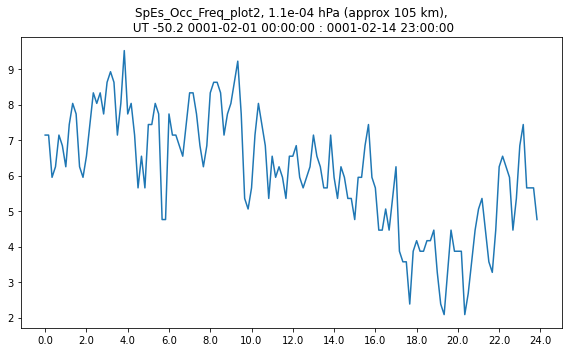

In [45]:
#---------------Set up plot variables----------------------------

SpEs_Occ_Freq_plot3 = SpEs_Occ_Freq[lev_sl_plot1_idx,lat_plot2_idx,:]

#------------------------ SpEs_sh_freq_time_plot2  -----------------------------

#ticks = np.linspace(0, 12, 13)

fig, ax = plt.subplots(figsize=(8, 5))

C = ax.plot(timeconv_plot, SpEs_Occ_Freq_plot3)

#ax.set_ylabel('Latitude')
ax.set_xticks(np.linspace(0,24,13)) 
#ax.set_xticklabels(LT_plot_ticks[::2]) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title('SpEs_Occ_Freq_plot2, ' + lev_sl_plot1_str + ' (approx ' + Zavg_sl_plot1_str + '),\n UT ' + lat_plot2_str + ' ' + times_str_min + ' : ' + times_str_max  )

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

#cbar = fig.colorbar(C, pad=0.07)#,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

#cbar.set_label(r'%')

figname='SpEs_Occ_Freq_plot2: ' + lev_sl_plot1_str + lat_plot2_str + ' ' + times_str_min + ' : ' + times_str_max + '.png'
plt.tight_layout()
#plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/'+str(figname), dpi = 300) #